In [ ]:
import os

# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#NLP
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


In [ ]:
os.chdir('res')

In [ ]:
# load dataset
df = pd.read_csv('mtsamples.csv')
df.tail()

In [ ]:
df.isna().sum()

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df = df[df['transcription'].notna()]
df.isna().sum()

In [ ]:
data_categories = df.groupby(df['medical_specialty'])

i = 0
for cat_name, data_category in data_categories:
    i += 1
    print(f'Category_{i} : {cat_name} : {len(data_category)}')

In [ ]:
filtered_data_categories = data_categories.filter(lambda x : x.shape[0] > 50)
data_categories = filtered_data_categories.groupby(df['medical_specialty'])

i = 0
for cat_name, data_category in data_categories:
    i += 1
    print(f'Category_{i} : {cat_name} : {len(data_category)}')

In [ ]:
plt.figure()
sns.countplot(y = 'medical_specialty', data = filtered_data_categories, palette = 'Set2')
plt.show()

In [ ]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data

In [ ]:
data.isna().sum()

In [ ]:
def clean_text(text):
    text = text.translate(str.maketrans("","",string.punctuation)) # noktalama isaretlerini kaldir.
    
    text1 = "".join([w for w in text if not w.isdigit()])
    
    replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
    
    text2 = text1.lower()
    text2 = replace_by_space_re.sub("", text2)
    
    return text2

In [ ]:
def lemmatize_text(text):
    wordlist = []
    lemmatizer = WordNetLemmatizer()
    
    sentences = sent_tokenize(text)
    
    initial_sentence = sentences[0:1]
    final_sentence = sentences[len(sentences)-2:len(sentences)-1]
    
    for sentence in initial_sentence:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))

    for sentence in final_sentence:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return " ".join(wordlist)

In [ ]:
data["transcription2"] = data["transcription"].apply(lemmatize_text)
data["transcription2"] = data["transcription2"].apply(clean_text)

In [24]:
# numerical representation of text data

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf = vectorizer.fit_transform(data["transcription"].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())

In [25]:
labels = data["medical_specialty"].tolist()
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(tfidf.toarray())

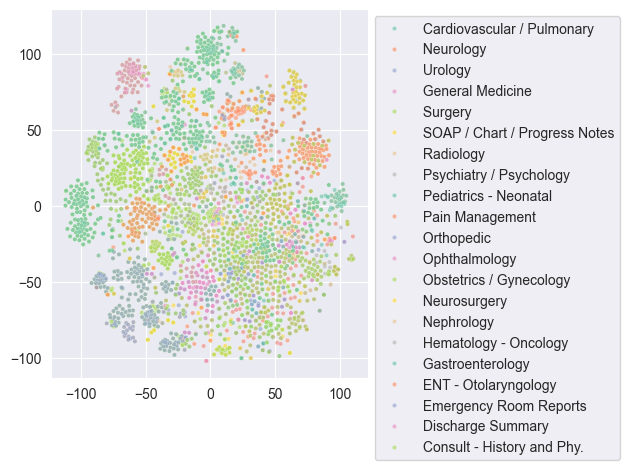

In [30]:
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, s=10, alpha=0.6, palette='Set2')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout() 
plt.show()

In [31]:
# PCA analysis dimension reduction, training : logistic regression
pca = PCA()
tfidf_reduced =  pca.fit_transform(tfidf.toarray())
labels = data["medical_specialty"].tolist()
category_list = data.medical_specialty.unique()

category_list

array([' Cardiovascular / Pulmonary', ' Neurology', ' Urology',
       ' General Medicine', ' Surgery', ' SOAP / Chart / Progress Notes',
       ' Radiology', ' Psychiatry / Psychology', ' Pediatrics - Neonatal',
       ' Pain Management', ' Orthopedic', ' Ophthalmology',
       ' Obstetrics / Gynecology', ' Neurosurgery', ' Nephrology',
       ' Hematology - Oncology', ' Gastroenterology',
       ' ENT - Otolaryngology', ' Emergency Room Reports',
       ' Discharge Summary', ' Consult - History and Phy.'], dtype=object)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_reduced, labels, test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [33]:
y_pred = lr.predict(X_test)

<Axes: >

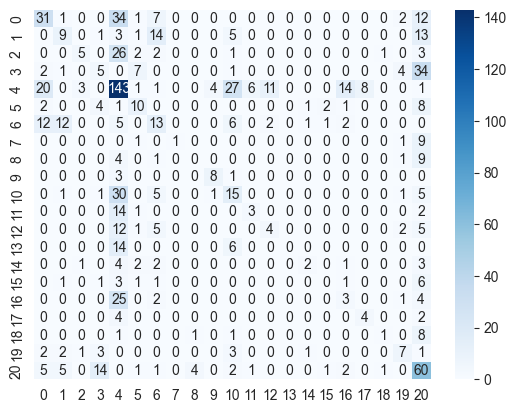

In [38]:
cm = confusion_matrix(y_test, y_pred, labels=category_list)

sns.heatmap(data=cm, annot=True,  cmap = 'Blues', fmt = 'g')

In [39]:
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.42      0.35      0.38        88
    Consult - History and Phy.       0.32      0.62      0.43        97
             Discharge Summary       0.37      0.35      0.36        20
          ENT - Otolaryngology       0.33      0.40      0.36        10
        Emergency Room Reports       0.33      0.08      0.13        12
              Gastroenterology       0.12      0.09      0.10        35
              General Medicine       0.17      0.09      0.12        54
         Hematology - Oncology       0.00      0.00      0.00        14
                    Nephrology       0.40      0.13      0.20        15
                     Neurology       0.28      0.20      0.23        46
                  Neurosurgery       0.00      0.00      0.00        20
       Obstetrics / Gynecology       0.24      0.14      0.17        29
                 Ophthalmology       0.30      0.15      0.20  